# Imports
Gathered imports used throughout the notebook

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay

# Loading Data and Raw Visuals
We start by loading the raw data file to see what it contians and understand its content.

In [82]:
data_raw = pd.read_csv('../data/raw/bank_data_raw.csv')

In [83]:
data_raw.head().T

,0,1,2,3,4
age,56,57,37,40,56
occupation,housemaid,services,services,admin.,services
marital_status,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
has_credit,no,unknown,no,no,no
housing_loan,no,no,yes,no,no
personal_loan,no,no,no,no,yes
contact_mode,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
week_day,mon,mon,mon,mon,mon


We have 20 features, of which 10 are numeric and 10 are categorical, as well as one target variable which is binary.

We start by viewing the numerical features distribution.

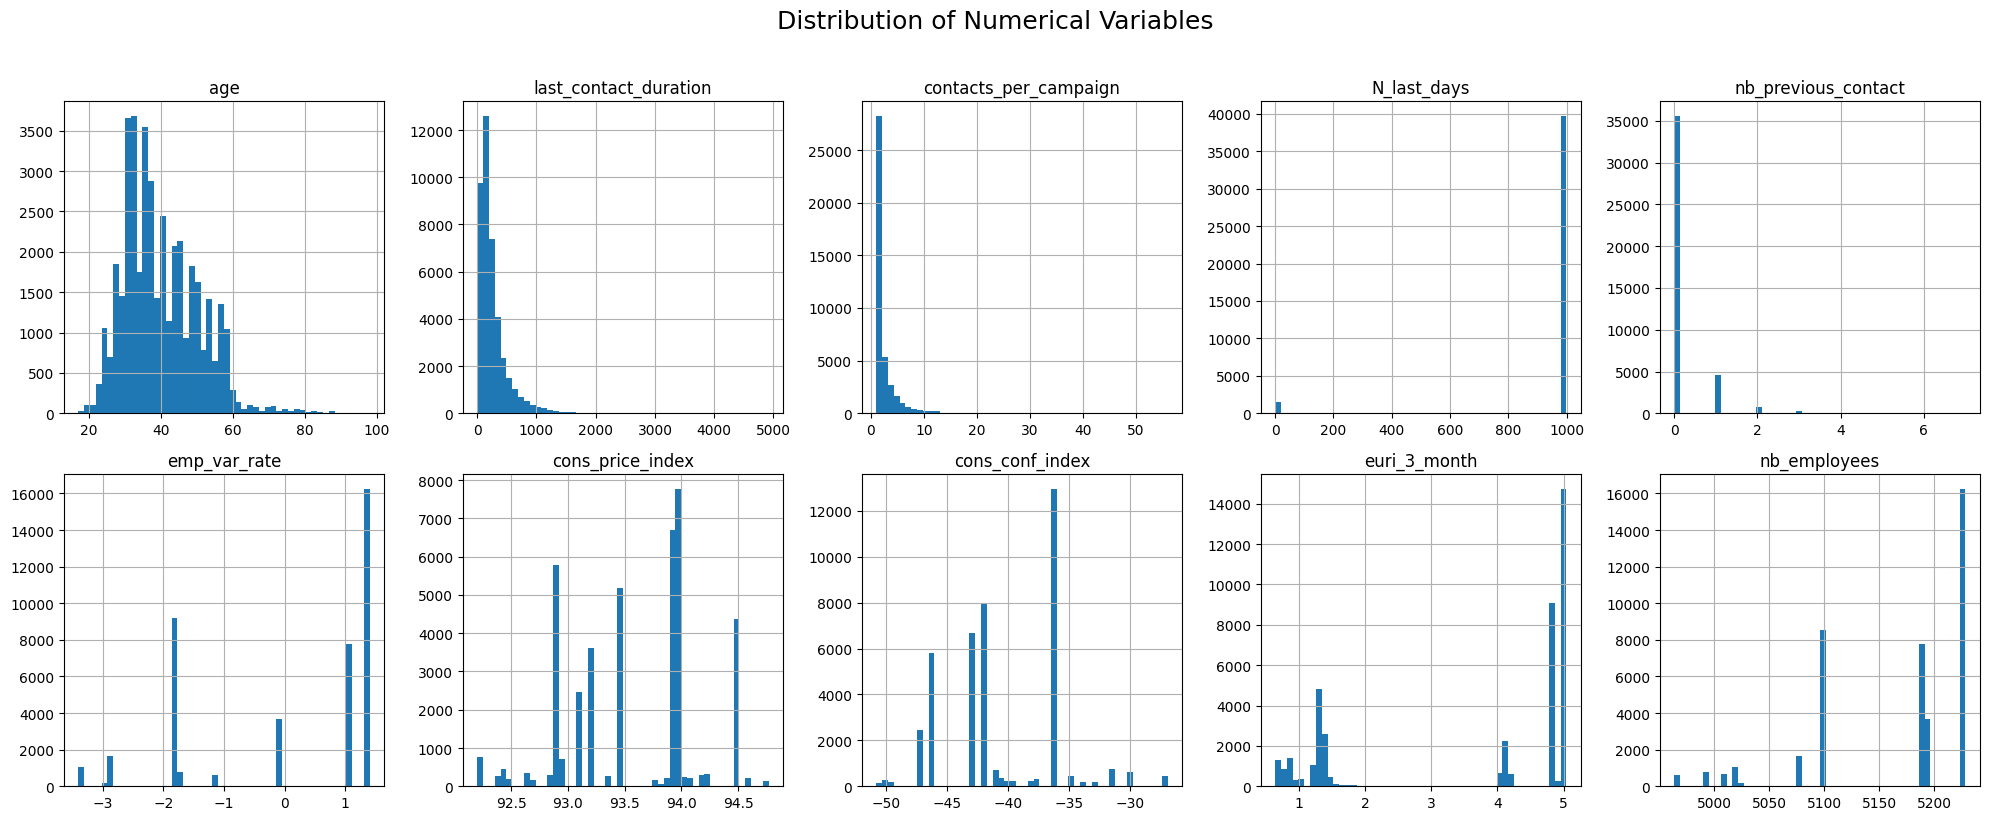

In [84]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
data_raw.hist(bins=50, ax=axes.flatten())
plt.suptitle("Distribution of Numerical Variables", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

From the visuals, we observe that age seem to be the only somewhat normally distributed feature.
last_contact_duration and contacts_per_campaign is skewed, and the rest are sparsely distributed with a majority of rows falling within small intervals. 

For N_last days, I visually suspect something to be wrong with the many values close to 1000, which I want to explore further. In addition we check for nan-values in the data.

In [85]:
data_raw["N_last_days"].value_counts().sort_index().to_frame().T

N_last_days,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,25,26,27,999
count,15,26,61,439,118,46,412,60,18,64,...,8,7,3,1,2,3,1,1,1,39673


In [86]:
# Check nan values in the dataset
data_raw.isna().sum()

age                      0
occupation               0
marital_status           0
education                0
has_credit               0
housing_loan             0
personal_loan            0
contact_mode             0
month                    0
week_day                 0
last_contact_duration    0
contacts_per_campaign    0
N_last_days              0
nb_previous_contact      0
previous_outcome         0
emp_var_rate             0
cons_price_index         0
cons_conf_index          0
euri_3_month             0
nb_employees             0
target                   0
dtype: int64

We have no initial nan-values but I assume 999 means missing value, which should be kept in mind.

Below we not take a look at the distribution of the categorical features: 

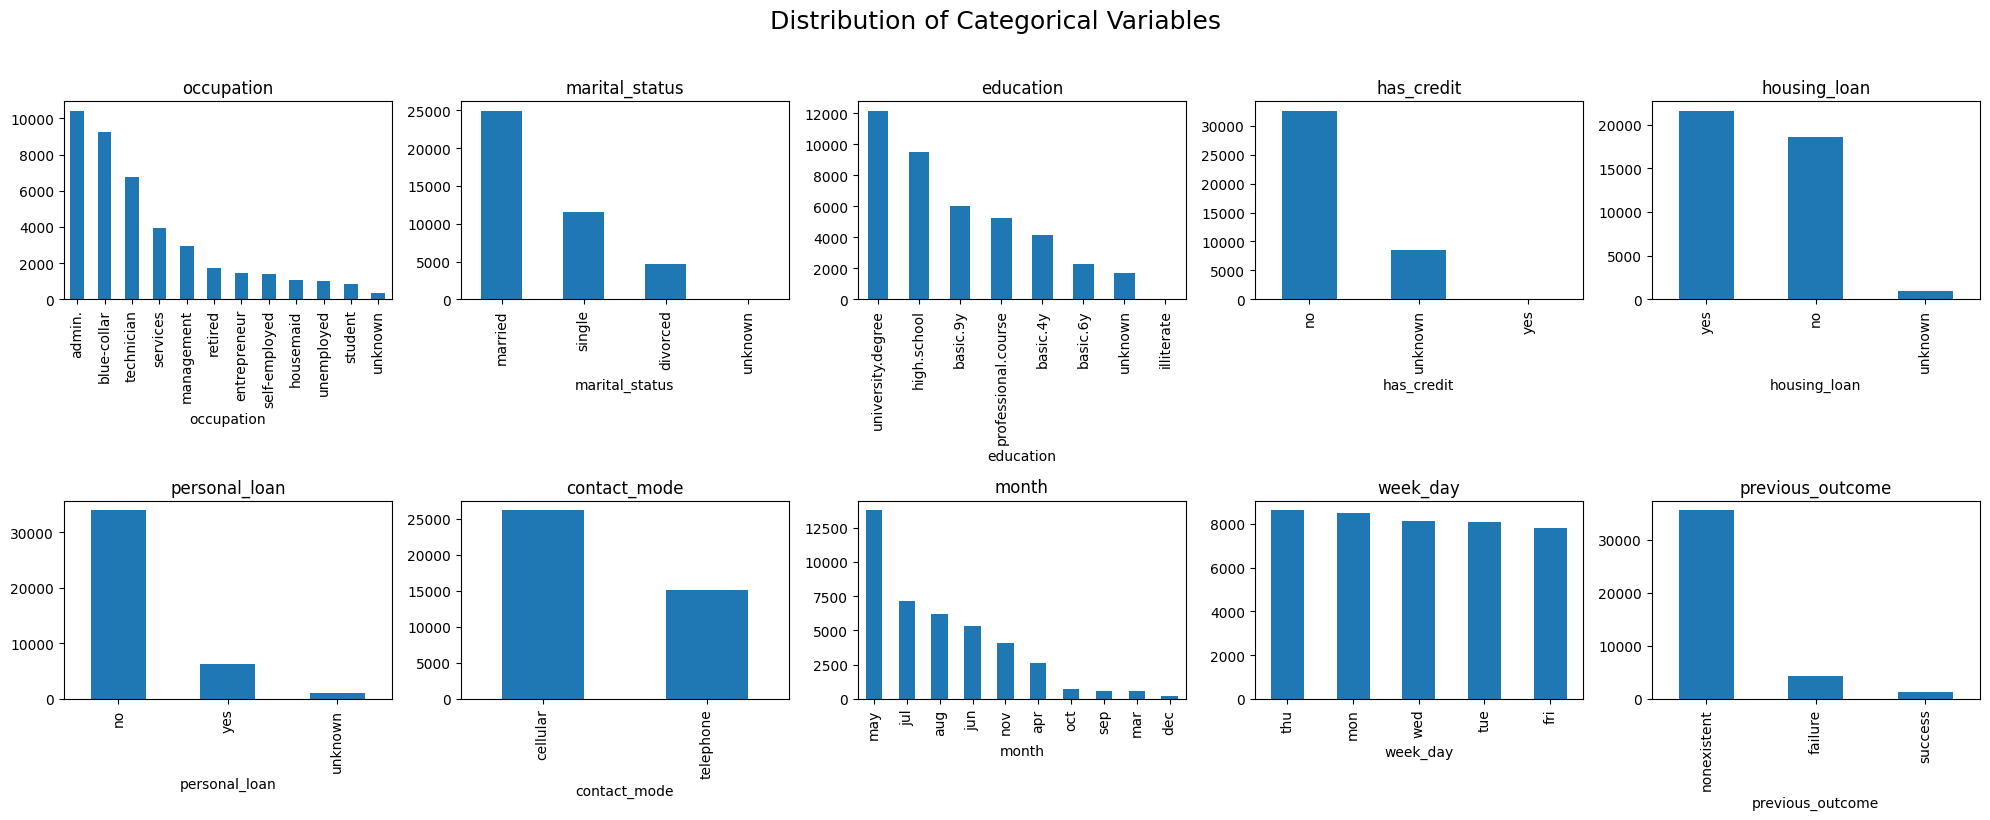

In [87]:
categorical_variables = [col for col in data_raw.select_dtypes(include=['object']).columns if col != 'target']

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()
for i, var in enumerate(categorical_variables):
    data_raw[var].value_counts().plot(kind='bar', ax=axes[i], title=var)
plt.suptitle("Distribution of Categorical Variables", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

For some of the features like has_credit and previous_outcome the distribution of classes are only seen a few times, with the majority falling into the other categorie and thus these features might help a lot in the classification-decision. But for has_credit for instance, the despite "yes" is only seen 3 times (see below) then the differentiation between no and unknown might contain value.

In [88]:
data_raw["has_credit"].value_counts().sort_index().to_frame().T

has_credit,no,unknown,yes
count,32588,8597,3


To better see how the features relate to the target variable, I also look at the normalized distribution of target within each class.

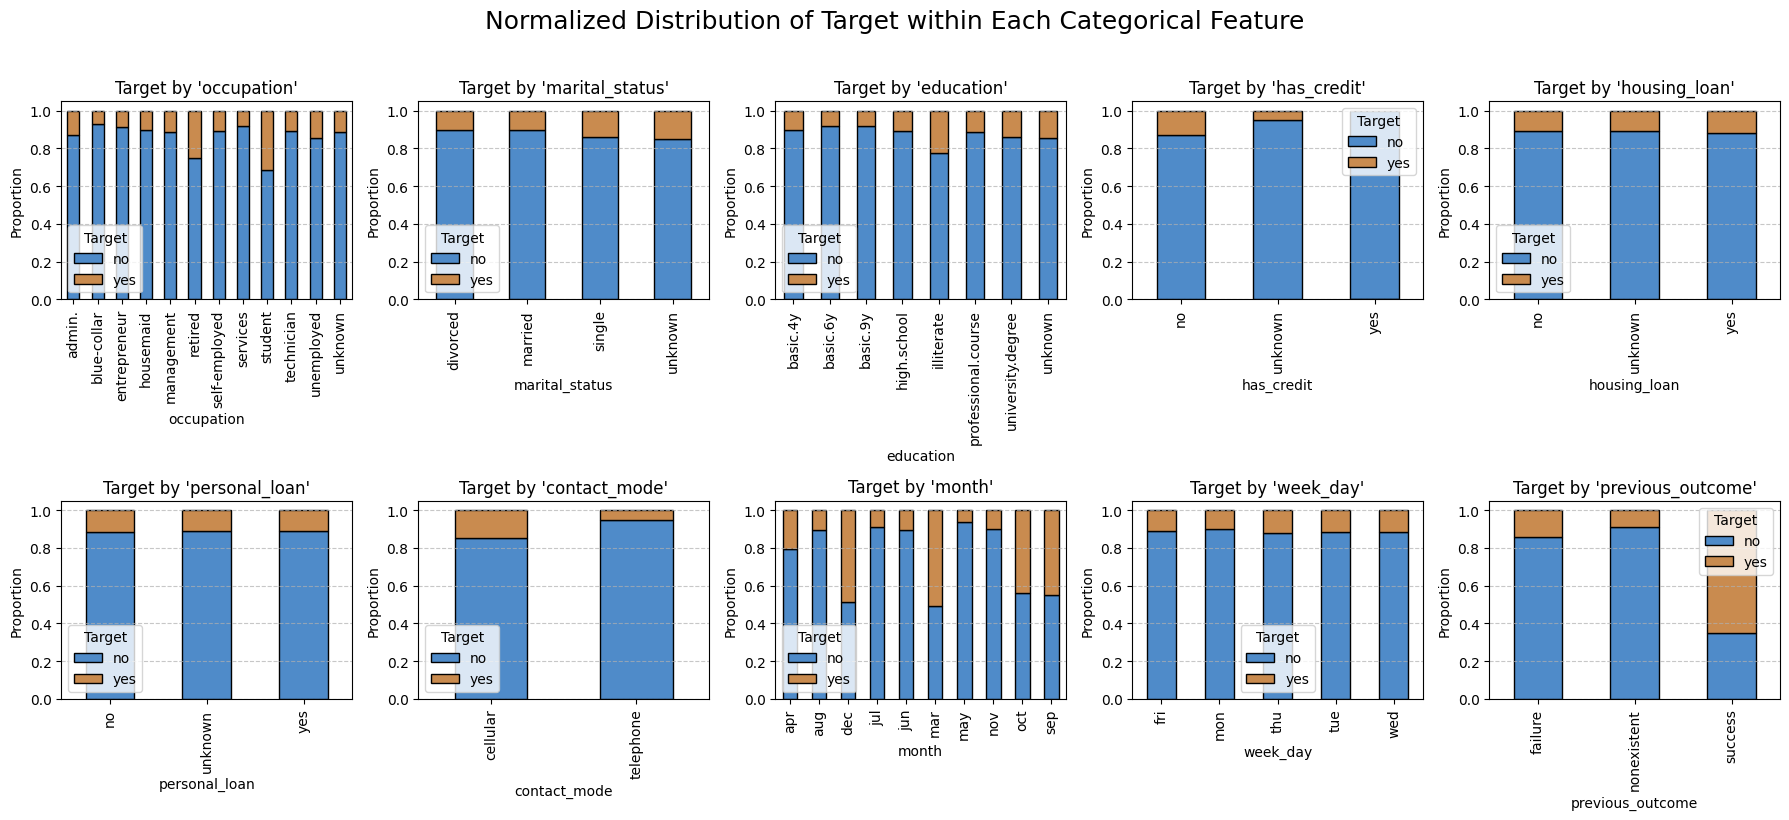

In [89]:
n_rows = 2
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 8))
fig.suptitle("Normalized Distribution of Target within Each Categorical Feature", fontsize=18, y=1.02)
axs = axs.flatten()

for i, c in enumerate(categorical_variables):
  ct = pd.crosstab(data_raw[c], data_raw['target'])
  ct_norm = ct.div(ct.sum(axis=1), axis=0)
  ct_norm.plot(kind='bar', stacked=True, ax=axs[i], color=['#4f8bc9', '#c98b4f'], edgecolor='black')
  axs[i].set_title(f"Target by '{c}'", fontsize=12)
  axs[i].set_xlabel(c, fontsize=10)
  axs[i].set_ylabel("Proportion", fontsize=10)
  axs[i].grid(axis='y', linestyle='--', alpha=0.7)
  axs[i].tick_params(axis='x', rotation=90)
  axs[i].legend(title='Target')

for j in range(len(categorical_variables), n_rows * n_cols):
  fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


We observe that some features like previous success (maybe not so surprisingly) has a far greater proportion of adopters among the successful group compared to the rest. However it is important to keep in mind that the successful group only constituted a very small proportion of all data. 

We also observe that groups like retired occupation and student occupation have higher adoption rates than the rest of the occupation groups and that some months like july, march, october and september also have higher adoption rates than the rest. Also, cellular contact_mode has a visually higher adoption rate than the telephone contact_mode. 

For the remaining features the distribution seem more even. Although this gives us an initial understanding of the data, including all features will allow a model to capture unseen interactions and subtle patterns, so we don't miss predictive information.

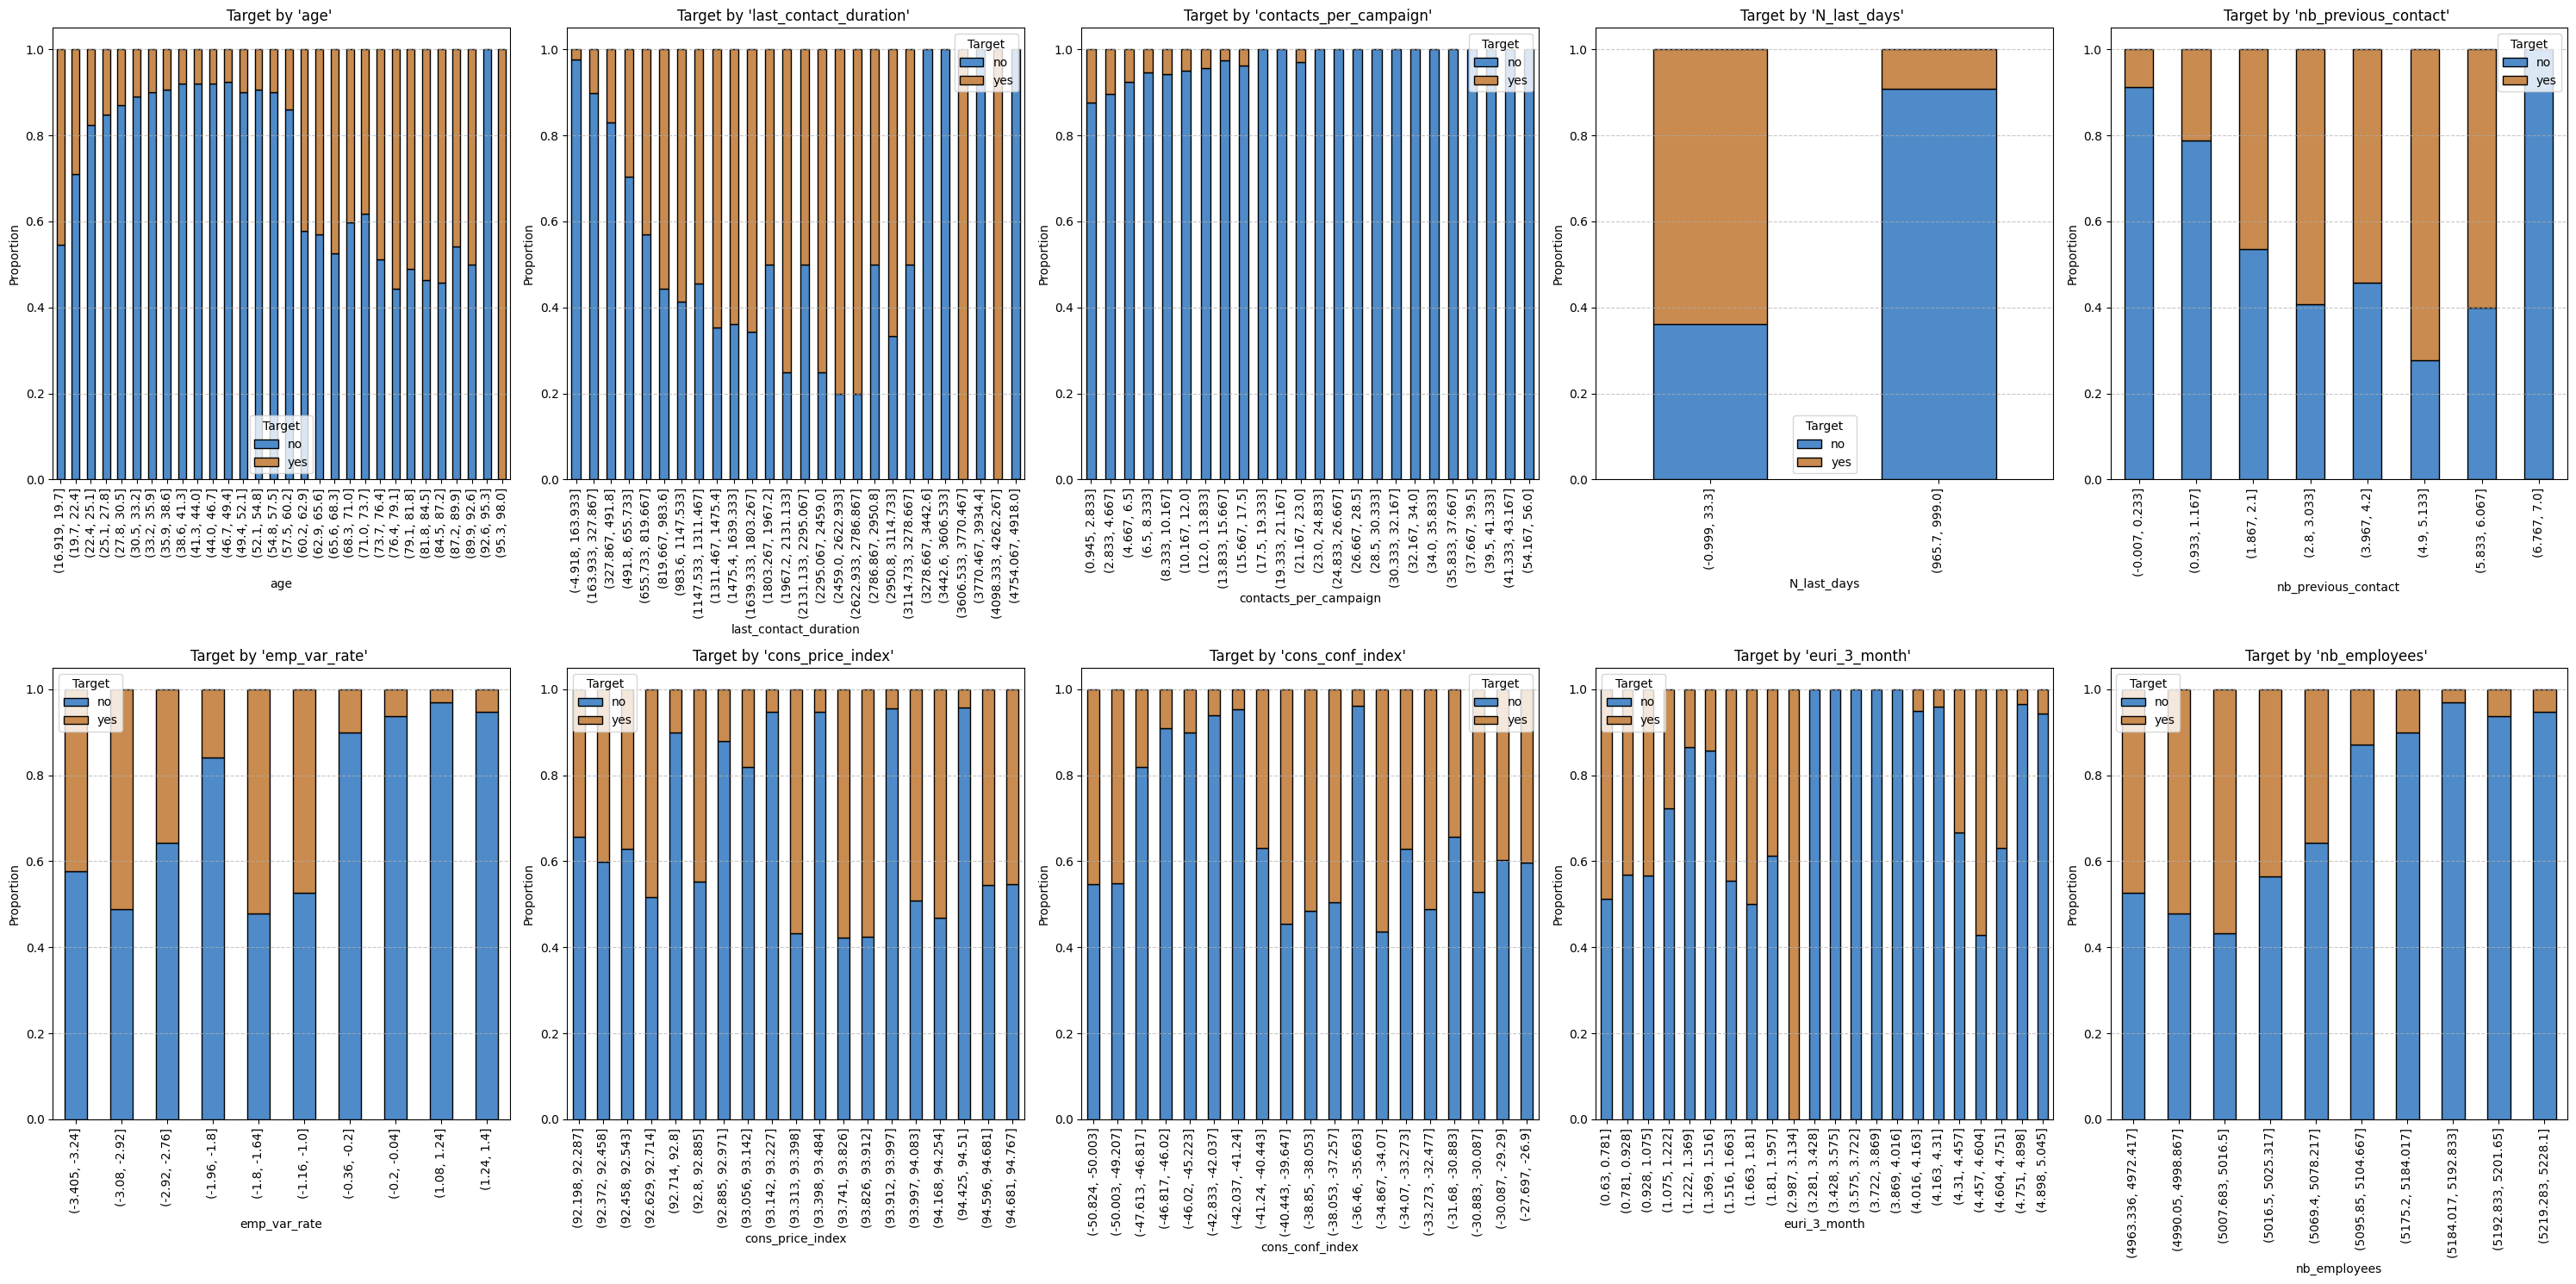

In [90]:
numerical_variables = data_raw.select_dtypes(include=[np.number]).columns.tolist()

n_rows = 2
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(30, 15))
axs = axs.flatten()

for i, c in enumerate(numerical_variables):
  bins = 30
  binned = pd.cut(data_raw[c], bins=bins)
  ct = pd.crosstab(binned, data_raw['target'])
  ct_norm = ct.div(ct.sum(axis=1), axis=0)
  ct_norm.plot(kind='bar', stacked=True, ax=axs[i], color=['#4f8bc9', '#c98b4f'], edgecolor='black')
  axs[i].set_title(f"Target by '{c}' ", fontsize=12)
  axs[i].set_xlabel(c, fontsize=10)
  axs[i].set_ylabel("Proportion", fontsize=10)
  axs[i].grid(axis='y', linestyle='--', alpha=0.7)
  axs[i].tick_params(axis='x', rotation=90)
  axs[i].legend(title='Target')

for j in range(len(numerical_variables), n_rows * n_cols):
  fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


For the numerical values we observe in general less uniform distributions of the target all throughout. Inteerestingly we see that adoption is higher among the elderly half of the age distribution. We also observe that contacts_per_campaign has a diminishing returns, with no successful adoptions among the ones that were contacted more than 23 times. This category only accounts for a very small percentage though which must be kept in mind.  

We observe that the bins in the N_last_days plot are heavily influenced by the 999 values, so below we also visualize the N_last_days for the values excluding 999.

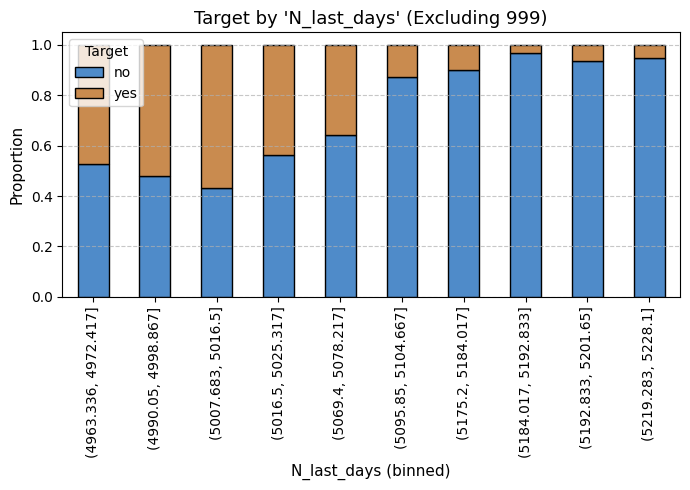

In [91]:
fig, ax = plt.subplots(figsize=(7, 5))
ct_norm.plot(kind='bar', stacked=True, ax=ax, color=['#4f8bc9', '#c98b4f'], edgecolor='black')
ax.set_title("Target by 'N_last_days' (Excluding 999)", fontsize=13)
ax.set_xlabel("N_last_days (binned)", fontsize=11)
ax.set_ylabel("Proportion", fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title='Target')
plt.tight_layout()
plt.show()


Lastly I want to see the distribution of the target variable across all data.

In [92]:
data_raw["target"].value_counts(normalize=True).to_frame().T

target,no,yes
proportion,0.887346,0.112654


This imbalance matches expectations, only 11% of the historical campaigns led to successful customer adoptation. It is very important to keep in mind though when evaluating a model, as a baseline classifier that always predicts no would obtain 88.7% accuracy. This should be kept in mind during evaluation.

# Preprocessing of data
We now need to preprocess the features for the classification problem. 

This process depends on the model choice. I wish to use logistic regression as a simple baseline model which assume linearly seperable classes, and that is sensitive to feature values on different scales, I handle skewness through log-transformation and standardize the numerical features to 0 mean and unit variance.

For the categorical features, we keep the unknown as a potentially useful feature, and one-hot encode the classes. I could consider turning for instance the educational level into a number ordering, as there is some ordinal relationship between them (more or less educated) but I am not sure how to interpret the classes specifically so I choose to one-hot encode these as well. 

For comparison I want to compare the linear LogReg with a random forrest, which can capture non-linearities. Although RF dont rely on standardization as it uses thresholds, it does not harm the model so we can keep the  preprocessing the same for both setups. 

For the N_last_days where we had a majority of missing classes, I impute them using a median value. I also considered binning the values into ranges, but based on the visuals from before I wish to keep the uniqueness for each value as we saw some differences on target distribution even for small changes in feature value.

As a first step we split the data into a hold out test-set and a remaining training data set.

In [236]:
# Separate features and target
X = data_raw.drop(columns=['target'])
y = data_raw['target']

# Map target labels to binary values
y = y.map({'yes': 1, 'no': 0})

# Stratified split to maintain target distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

We then define a preprocessing pipeline implementing the chosen steps.

In [245]:
# Custom transformer for log1p
log_transformer = FunctionTransformer(np.log1p)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("n_last_days", Pipeline([
            ("imputer", SimpleImputer(missing_values=999, strategy="median")),
            ("scaler", StandardScaler())
            ]), ["N_last_days"]),
        ("skew", Pipeline([
            ("log", FunctionTransformer(np.log1p)),
            ("scaler", StandardScaler())
            ]), ["last_contact_duration", "contacts_per_campaign"]),
        ("cat", OneHotEncoder(drop="first",sparse_output=False), ['occupation','marital_status','education','has_credit','housing_loan','personal_loan','contact_mode','month','week_day','previous_outcome']),
        ("num", StandardScaler(), ['age', 'nb_previous_contact', 'emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees'])
    ],
    remainder="passthrough"
)

### Below was my initial manual way, turned to the pipeline for efficiency afterwards

In [ ]:
# Fix the missing N_last_days 
# data_cleaned['N_last_days'] = data_cleaned['N_last_days'].replace(999, np.nan)
# median_value = data_cleaned['N_last_days'].median()
# data_cleaned['N_last_days'] = data_cleaned['N_last_days'].fillna(median_value)

# Log transform highly skewed features
# skewed_features = ["last_contact_duration", "contacts_per_campaign"]
# data_cleaned[skewed_features] = data_cleaned[skewed_features].apply(lambda x: np.log1p(x))

# One-hot encoding of categorical features. Causes more features (55) but we have 40k+ samples so not an issue.
# One hot encode all the categorical variables
# categorical_variables_no_target = [col for col in categorical_variables if col != 'target']
# data_cleaned = pd.get_dummies(data_cleaned, columns=categorical_variables_no_target, drop_first=True)

# Standardize the numerical features to be on same scale
# scaler = StandardScaler()
# data_cleaned[numerical_variables] = scaler.fit_transform(data_cleaned[numerical_variables])

# Model Training

With data processing defined, we move on to the model training.

As mentioned we use a Logistic regression baseline and a random forrest candidate for comparison. We use a balanced class weighting in both setups due to the imbalances.

For the Logistic Regression I explore different regularization types and strengths.

For the Random Forrest I explore varying the number of trees used, there depth and the number of features selected in the nodes.

In [252]:
# Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced'))
])

lr_param_grid = {
    "model__C": [0.01, 0.1, 1, 10],        # Regularization strength
    "model__penalty": ["l1", "l2"]         # Regularization type
}

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

rf_param_grid = {
    "model__n_estimators": [50, 100, 200],   # Number of trees
    "model__max_depth": [5, 10, 20],         # Tree depth
    "model__max_features": ["sqrt", "log2"]  # Features per split
}

I use an inner 5-fold cv-loop to find optimal hyperparameters.

In [253]:
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Logistic Regression

In [254]:
# Grid search with pipeline
lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=cv_inner,
                       scoring='roc_auc', n_jobs=-1, return_train_score=True)

lr_grid.fit(X_train, y_train)
print("Best LR params:", lr_grid.best_params_)

Best LR params: {'model__C': 1, 'model__penalty': 'l1'}


Training and validation performance

In [255]:
# Show train and validation scores for the best model
train_mean = lr_grid.cv_results_['mean_train_score'][lr_grid.best_index_]
train_std  = lr_grid.cv_results_['std_train_score'][lr_grid.best_index_]
val_mean   = lr_grid.cv_results_['mean_test_score'][lr_grid.best_index_]
val_std    = lr_grid.cv_results_['std_test_score'][lr_grid.best_index_]

print("Fold-wise CV ROC AUC scores (mean ± std):")
print(f"Train ROC AUC: {train_mean:.3f} ± {train_std:.3f}")
print(f"Val   ROC AUC: {val_mean:.3f} ± {val_std:.3f}\n")

Fold-wise CV ROC AUC scores (mean ± std):
Train ROC AUC: 0.938 ± 0.001
Val   ROC AUC: 0.936 ± 0.003



Test Performance

In [256]:
# Predict on the test set
y_pred_lr = lr_grid.predict(X_test)
print(f"\nLogistic Regression Test AUC: {roc_auc_score(y_test, lr_grid.predict_proba(X_test)[:,1]):.2f}\n")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Test AUC: 0.94

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      7310
           1       0.44      0.92      0.60       928

    accuracy                           0.86      8238
   macro avg       0.72      0.89      0.76      8238
weighted avg       0.93      0.86      0.88      8238



### Random Forrest

In [258]:
# Grid search with cross-validation for RF
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=cv_inner, scoring='roc_auc', n_jobs=-1, return_train_score=True)
rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)

Best RF params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 200}


Trainind and Validation Performacne

In [259]:
train_mean = rf_grid.cv_results_['mean_train_score'][rf_grid.best_index_]
train_std  = rf_grid.cv_results_['std_train_score'][rf_grid.best_index_]
val_mean   = rf_grid.cv_results_['mean_test_score'][rf_grid.best_index_]
val_std    = rf_grid.cv_results_['std_test_score'][rf_grid.best_index_]

print("Fold-wise CV ROC AUC scores (mean ± std):")
print(f"Train ROC AUC: {train_mean:.3f} ± {train_std:.3f}")
print(f"Val   ROC AUC: {val_mean:.3f} ± {val_std:.3f}\n")

Fold-wise CV ROC AUC scores (mean ± std):
Train ROC AUC: 1.000 ± 0.000
Val   ROC AUC: 0.941 ± 0.004



In [260]:
y_pred_rf = rf_grid.predict(X_test)
print(f"Random Forest Test AUC: {roc_auc_score(y_test, rf_grid.predict_proba(X_test)[:,1]):.2f}\n")
print(classification_report(y_test, y_pred_rf))

Random Forest Test AUC: 0.95

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      7310
           1       0.62      0.65      0.63       928

    accuracy                           0.92      8238
   macro avg       0.79      0.80      0.79      8238
weighted avg       0.92      0.92      0.92      8238



### Comparison
We find that the Random Forrest is able to achieve slightly higher test-AUC, and when looking at the precision-recall tradeoffs the f1 is higher for RF in both the 0 and 1-class. This is a result of the more balanced precision-recall where the logistic regression scores much more uneven. 

To see the effect of varying the decision threshold we can look at the ROC curve and precicsion-recall curves to better see the difference in performance, not restricting ourselves to one threshold. 

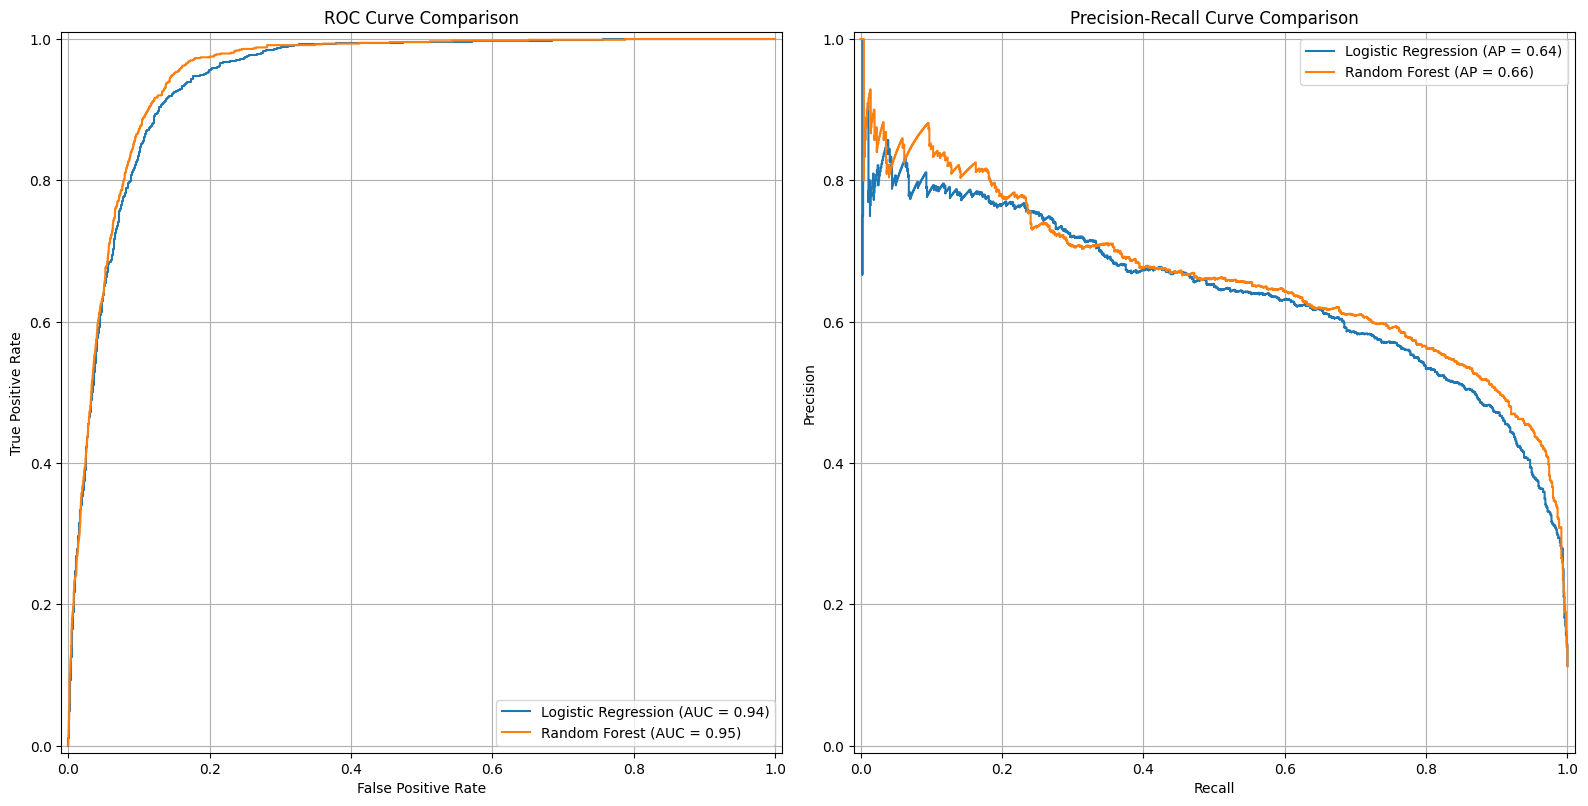

In [261]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ROC Curve
RocCurveDisplay.from_estimator(lr_grid, X_test, y_test, name="Logistic Regression", ax=axes[0])
RocCurveDisplay.from_estimator(rf_grid, X_test, y_test, name="Random Forest", ax=axes[0])
axes[0].set_title('ROC Curve Comparison')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid()

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(lr_grid, X_test, y_test, name="Logistic Regression", ax=axes[1])
PrecisionRecallDisplay.from_estimator(rf_grid, X_test, y_test, name="Random Forest", ax=axes[1])
axes[1].set_title('Precision-Recall Curve Comparison')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

Again we see very similar performance but throughout most thresholds the RF slightly outperforms the LR.

To better evaluate the models in the given context we need to understand what the true positives (TP), false positives (FP), and false negatives (FN) mean in practice. In this case, it reflects the trade-off between the gain from a customer saying yes, the cost of contacting a customer who does not accept the offer, and the opportunity cost of missing a potential yes by not calling them.

If we define:  

- $G$ = gain from a positive response (customer says yes)  
- $C$ = cost of contacting a customer who says no  
- $M$ = opportunity cost of missing a potential positive response  

we can explore different settings to identify a suitable decision threshold for the model.  

For example, assuming:  

- $G = 100$ DKK  
- $C = 10$ DKK
- $M = 90$ DKK  

we can plot the expected profit for the test set predictions across varying decision thresholds, helping us select the threshold that maximizes net gain.

In [262]:
def profit_curve(y_true, y_proba, G=100, C=10, M=90, n_thresholds=1000):
    
    thresholds = np.linspace(0, 1, n_thresholds)
    profits = []

    # For each threshold, calculate profit
    for t in thresholds:
        
        # Extract predictions based on threshold
        y_pred = (y_proba >= t).astype(int)
        
        # Extract confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate profit
        profit = (tp * G) - (fp * C) - (fn * M)
        profits.append(profit)

    return thresholds, np.array(profits)

Max LR profit: 71050 DKK at threshold 0.32
Max RF profit: 74960 DKK at threshold 0.14


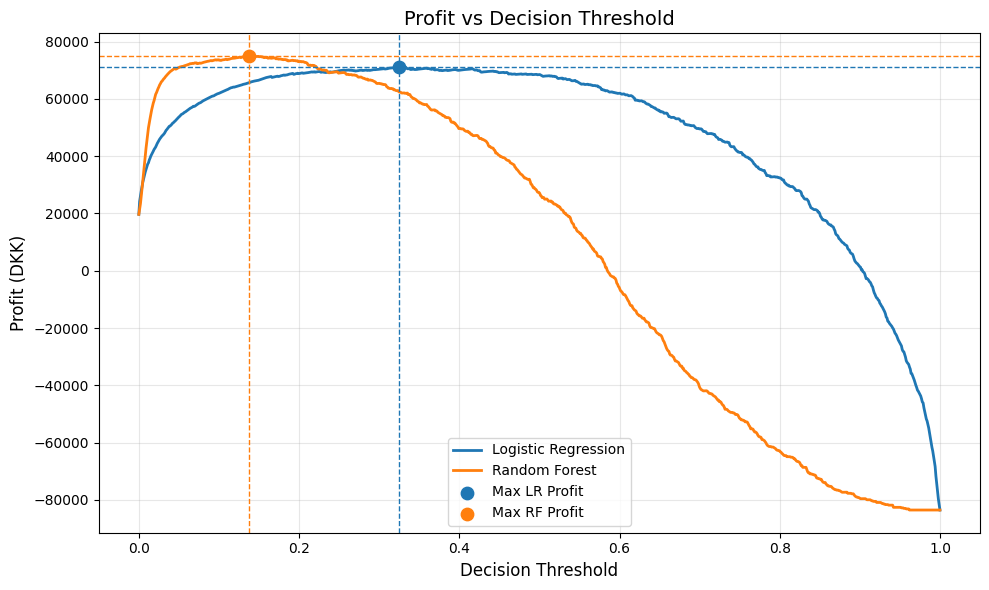

In [263]:
# Assumptions
G = 100   # gain per true positive
C = 10    # cost per false positive
M = 90    # missed opportunity per false negative

# Compute profit curves
proba_lr = lr_grid.predict_proba(X_test)[:, 1]
proba_rf = rf_grid.predict_proba(X_test)[:, 1]
th_lr, pr_lr = profit_curve(y_test, proba_lr, G=G, C=C, M=M)
th_rf, pr_rf = profit_curve(y_test, proba_rf, G=G, C=C, M=M)

# Find max points
max_idx_lr = pr_lr.argmax()
max_idx_rf = pr_rf.argmax()

# Print max profits
print(f"Max LR profit: {pr_lr[max_idx_lr]:.0f} DKK at threshold {th_lr[max_idx_lr]:.2f}")
print(f"Max RF profit: {pr_rf[max_idx_rf]:.0f} DKK at threshold {th_rf[max_idx_rf]:.2f}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(th_lr, pr_lr, label="Logistic Regression", color='#1f77b4', linewidth=2)
plt.plot(th_rf, pr_rf, label="Random Forest", color='#ff7f0e', linewidth=2)
plt.scatter(th_lr[max_idx_lr], pr_lr[max_idx_lr], color='#1f77b4', s=80, marker='o', label='Max LR Profit')
plt.scatter(th_rf[max_idx_rf], pr_rf[max_idx_rf], color='#ff7f0e', s=80, marker='o', label='Max RF Profit')
plt.axvline(x=th_lr[max_idx_lr], color='#1f77b4', linestyle='--', linewidth=1)
plt.axhline(y=pr_lr[max_idx_lr], color='#1f77b4', linestyle='--', linewidth=1)
plt.axvline(x=th_rf[max_idx_rf], color='#ff7f0e', linestyle='--', linewidth=1)
plt.axhline(y=pr_rf[max_idx_rf], color='#ff7f0e', linestyle='--', linewidth=1)
plt.xlabel("Decision Threshold", fontsize=12)
plt.ylabel("Profit (DKK)", fontsize=12)
plt.title("Profit vs Decision Threshold", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Although the assumptions are arbitrary we again observe better performance for the RF, which for the test set and given assumptions would lead to the most profit.

### Important Features

If we wish to understand what features are important for the decision we can then 

In [266]:
# Random Forest: top 10 by feature importance
rf_best = rf_grid.best_estimator_
rf_importances = pd.Series(rf_best.named_steps['model'].feature_importances_, index=X_processed.columns)
rf_top_features = rf_importances.sort_values(ascending=False).head(10)

print("Top 10 features - Random Forest (feature importance):")
display(rf_top_features)

Top 10 features - Random Forest (feature importance):


last_contact_duration           0.400595
previous_outcome_nonexistent    0.098579
previous_outcome_success        0.062616
week_day_thu                    0.060889
month_sep                       0.050425
week_day_wed                    0.033429
contacts_per_campaign           0.026485
week_day_tue                    0.025823
month_oct                       0.018940
education_unknown               0.014331
dtype: float64

We observe that the most important features for the Random Forest include both customer-specific behavioral indicators, such as `last_contact_duration` and `previous_outcome_*` (including `nonexistent` and `success`), as well as temporal patterns like `week_day_*` and `month_*`. This suggests that both individual customer behavior and the timing of the contact play a key role in predicting a positive response. Features like `contacts_per_campaign` and `education_unknown` also contribute, though to a smaller extent, indicating that campaign history and demographic information have some predictive value as well.

# Train and save Final Model and Preprocessor for Serving 

As a last step before saving the model, we retrain the model model on all data, ready for new unseen data. We also save a preprocessing object for preprocessing new incoming data, which will help us make the serving of our model easy.

In [269]:
# Retrain RF pipeline on entire dataset
best_rf_pipeline = Pipeline([
  ("preprocessor", preprocessor),
  ("model", RandomForestClassifier(
    n_estimators=rf_grid.best_params_['model__n_estimators'],
    max_depth=rf_grid.best_params_['model__max_depth'],
    max_features=rf_grid.best_params_['model__max_features'],
    random_state=42,
    class_weight="balanced"
  ))
])
best_rf_pipeline.fit(X, y)

# Save the final model
joblib.dump(best_rf_pipeline, '../models/best_rf_pipeline.pkl')

['../models/best_rf_pipeline.pkl']

Small test for the saved pipeline inference

In [278]:
# Loading trained pipeline for inference
pipeline_path = '../models/best_rf_pipeline.pkl'
pipeline = joblib.load(pipeline_path)


# Load raw data (simulating new incoming data)
raw_data = pd.read_csv('../data/raw/bank_data_raw.csv')


# Run data through the pipeline to get predictions
predictions = pipeline.predict(raw_data)
probas = pipeline.predict_proba(raw_data)[:, 1]
print("Predictions on new data:", predictions)
print("Prediction probabilities on new data:", np.round(probas, 2))

Predictions on new data: [0 0 0 ... 0 1 0]
Prediction probabilities on new data: [0.01 0.   0.01 ... 0.26 0.87 0.22]
